Author: Shusaku Asai  

Link to full blog post:  
https://delashu.github.io/bigdat/visualizations.html

Jupyter notebook repo:  
https://github.com/delashu/pysolve_notebooks/blob/main/viz.ipynb

Blog/website repo link:  
https://github.com/delashu/delashu.github.io/tree/master/bigdat  

# Visualizing Malaria 

Malaria is a public and global health problem that has placed heavy burden on individual health, community wellbeing, and economic growth. Malaria's effects are ever-present, as an approximate [409,000 individuals died of malaria in 2019.](https://www.cdc.gov/malaria/malaria_worldwide/impact.html)  

We use open source datasets from the [MalariaAtlas package](https://github.com/rfordatascience/tidytuesday/tree/master/data/2018/2018-11-13) to visualize Malaria's impact on the globe. Three visualizations are constructed. This blog-post will include the images of each of the visualizations and walk the reader through ideas and inference drawn from the graphs. Note that two of the visualizations are interactive. To maximize impact of the visualizations and allow for interactivity, click here.   
I use the [plotly](https://plotly.com) library to make the two of the visualization and interactive plots. I chose plotly for its ease of use in python, flexibility, dynamic features, interactive capabilities, and mapping abilities.   
The final plot is made with [seaborn](https://seaborn.pydata.org/). I selected seaborn since it allows for faceting and coloring of longitudinal line plots with relative ease.  
All computing is done in Python 3.7.8.  

We first prepare the data to be plotted. 

In [10]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.offline as py

In [11]:
#read in the three datasets provided as raw csv files
deaths = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_deaths.csv", 
                    names =["Country", "Code", "Year", "DPH"], header = 0)
deaths_age = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_deaths_age.csv",
                    names = ["Country","Code","Year","Age_group","Deaths"], header = 0)
inci = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_inc.csv",
                  names = ["Country", "Code", "Year", "Incidence"], header = 0)
#read in a cross-table also found on github
crostab = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
#rename columns
crostab = crostab.rename(columns = {'name':'Country', 'alpha-3':'Code'})

In [12]:
#merge columns from crosstable: 
deaths = deaths.merge(crostab[['Code','region','sub-region']], on = 'Code', how = 'left')
deaths_age = deaths_age.merge(crostab[['Code','region','sub-region']], on = 'Code', how = 'left')
inci = inci.merge(crostab[['Code','region','sub-region']], on = 'Code', how = 'left')

In [13]:
#remove data with no country code since we are interested in only the countries 
deathsdat = deaths.dropna(subset=['Code'])
deathsdat = deathsdat[~deathsdat.Code.isin(['OWID_WRL'])]

#subset to africa data
africa_deathdat = deathsdat[deathsdat.region.isin(['Africa'])]
africa_deathdat = africa_deathdat.sort_values(by = ['Year', 'DPH'], ascending = True)

#change values to be shortened for plotting aesthetics
africa_deathdat["Country"].replace({"Sao Tome and Principe": "STP",
                                    "Central African Republic": "CAR",
                                   "Democratic Republic of Congo" : "DRC",
                                   "Equatorial Guinea": "Eqt.Guinea"}, inplace=True)

## Mapping Malaria  
I first visualized longitudinal Malaria death rates (Maralia Deaths per 100,000 people) across the globe. The heat map shows which regions of the world are most affected by Malarial deaths by year. Use the play button to watch the map change with year through 1990 - 2016.  
The plot shows a substantial concentration of high malarial death rates in Africa, particularly in West Africa. 

In [15]:
fig = px.choropleth(
    deathsdat, 
    locations="Code",                    
    color="DPH",
    hover_name="Country",
    animation_frame="Year",
    range_color = (0,250),
    color_continuous_scale=px.colors.sequential.matter, 
    title = "Map of Maralia Deaths per 100k people in Africa (1990-2016)", 
    labels={'DPH': 'Deaths per 100k'}
)
fig.show()

This plot motivated a more specific look of Malaria in Africa. I subsetted the data to African countries to obtain a more granular view of the problem.  

## Pinpointing Malaria in Africa  
African countries were isolated from the malarial deaths dataset. I created a barplot where each bar represents each country's death rates. The plot is ordered from least deaths per 100k on the very left to most deaths per 100k on the very right.  
When the play button is clicked, as the years progress, the bars shift to represent the countries with the lowest and highest malarial death rates per 100k from 1990 - 2015.  

In [6]:
fig2 = px.bar(africa_deathdat, x="Country", y="DPH",
             animation_frame="Year", animation_group="Country",
             range_y = [0,250],
            labels={'Country': 'Country (Africa)', 'DPH':'Malaria Deaths per 100,000 people'},
            title="Maralia Deaths per 100k people in Africa (1990-2016)")
fig2.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
fig2.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 100
fig2.update_layout(margin=dict(l=20, r=20, t=30, b=200),paper_bgcolor="white")
fig2['layout']['updatemenus'][0]['pad']=dict(r= 10, t= 150)
fig2['layout']['sliders'][0]['pad']=dict(r= 5, t= 120,)
fig2.show()

During the early 90's Uganda, Sierrra Leone, Burundi, and Burkina Faso were affected the worst by malarial death rates. Burkina Faso and Sierra Leone continued to struggle through the 2000's and into 2016. Overall malarial death rates decreased from 1990 - 2016 as seen by the drop in bar heights.  

Now that the visualizations show which countries in Africa are most affected, I was curious which groupings of individuals were most affected by malarial deaths.  
The death rate dataset stratified by age was one source that would help with this investigation. 

## Who is Most Affected?  
I graphed longitudinal death rates in Africa faceted by age groupings. The age groupings provided in the dataset are the following: Under 5, 5-14, 15-49, 50-69, 70 or older. While graphing, I noticed three countries that stood out from the rest of the African countries: *Uganda, Nigeria, and the Democratic Republic of Congo*. These countries are colored separately.

In [7]:
#remove data with no country code after merging 
#since we are interested in only the countries 
deaths_agedat = deaths_age.dropna(subset=['Code'])
#subset to africa data
africa_deaths_agedat = deaths_agedat[deaths_agedat.region.isin(['Africa'])]
#create new column on the top three countries
africa_deaths_agedat = (africa_deaths_agedat.assign(Country_group = np.where(africa_deaths_agedat.loc[:,'Country']  == "Nigeria", "Nigeria", 
                                np.where(africa_deaths_agedat.loc[:,'Country'] == "Democratic Republic of Congo", "Democratic Republic of Congo", 
                                np.where(africa_deaths_agedat.loc[:,'Country']  == "Uganda", "Uganda", "All Other Countries"))))
                        .rename(columns={"Age_group": "Age Group", "Country_group": "Country Group"})
                       )

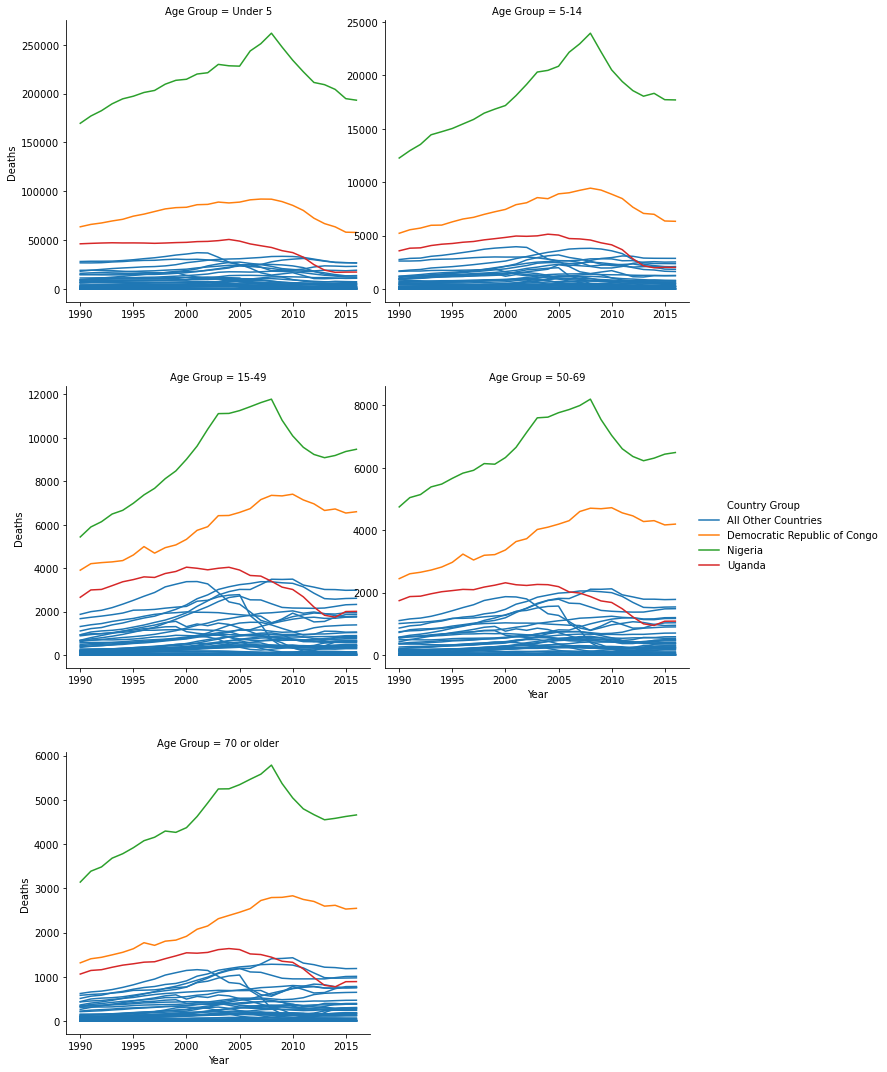

In [8]:
fig3 = sns.relplot(
    data=africa_deaths_agedat,
    x="Year", y="Deaths", col="Age Group",
    col_wrap = 2,estimator=None, color='.7',units = "Country",
    hue = "Country Group",
    col_order = ['Under 5', '5-14', '15-49', '50-69','70 or older'],
    kind="line", facet_kws={'sharey': False, 'sharex': False}
)
fig3.fig.subplots_adjust ( wspace=.05, hspace=.3 )

 


<font size="3">During the first pass of this graph, I used the " 'sharey' : False" parameter in seaborn. This gave all plots different y axes. In these plots, it was clear that  Uganda, Nigeria, and the Democratic Republic of Congo were affected most in nearly all age groupings. I then tweaked this parameter to be " 'sharey' : True", meaning all the plots shared the same y axis maximum and minimum. </font>

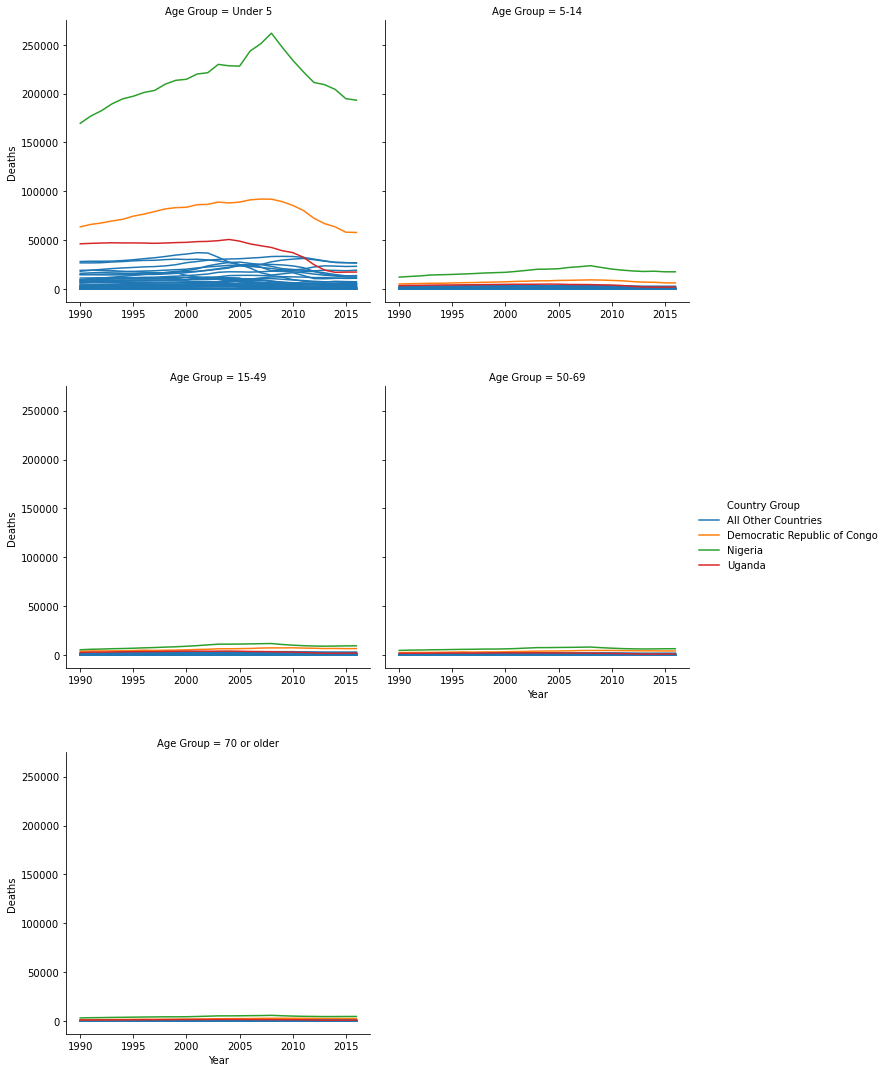

In [9]:
fig3 = sns.relplot(
    data=africa_deaths_agedat,
    x="Year", y="Deaths", col="Age Group",
    col_wrap = 2,estimator=None, color='.7',units = "Country",
    hue = "Country Group",
    col_order = ['Under 5', '5-14', '15-49', '50-69','70 or older'],
    kind="line", facet_kws={'sharey': True, 'sharex': False}
)
fig3.fig.subplots_adjust ( wspace=.05, hspace=.3 )

This change yields a different story to the data. While we know that Uganda, Nigeria, and the Democratic Republic of Congo were affected most, by making the y axis shared, it is clear that the Under 5 Age Grouping is affected most by Malarial Deaths across all countries in Africa. 